# Train and test split + Copying images into train and test folders

## 1. Reload images dataset

In [9]:
import pandas as pd

images_dataset_path = 'data/datasets/images_clean.csv'
df_images = pd.read_csv(images_dataset_path)

display(df_images.columns)
print()
display(df_images.index[:10])

Index(['id_video', 'code', 'folder', 'file_name', 'file_path', 'frame_index',
       'timestamp', 'initial_timestamp', 'seen', 'tags', 'tag', 'flood'],
      dtype='object')

RangeIndex(start=0, stop=10, step=1)

---
## 2. Preprocess the dataset

#### Drop categories

In [10]:
df_images = df_images[df_images['tag'] != 'transbordo']

#### Filter images

In [11]:
query_params = {'seen': True}

from modules.octa_video_util import filter_by_query

# Filter dataset of images by query
df_images = filter_by_query(df_images, query_params).copy()

display(df_images['flood'].value_counts())
print()
display(df_images.index[:10])

flood
0    224682
1     20865
Name: count, dtype: int64

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64')

---
## 3. Preparation

#### General sampling parameters

In [12]:
replace = False
random_state = 0

# Copy the data for analysis
data = df_images.copy()

#### Shuffle Samples

In [13]:
data = data.sample(n=len(data), replace=replace, random_state=random_state)

display(data.index[:10])

Index([85878, 119988, 83434, 112260, 87540, 168399, 36827, 129672, 82703,
       46108],
      dtype='int64')

#### Define x and y

In [14]:
x = data.drop('flood', axis=1)
y = data['flood']
y_multi = data['tag']
groups = data['code']

print('Total samples:', len(y))
print()
display(y.value_counts())
print()
print(y_multi.value_counts())

Total samples: 245547



flood
0    224682
1     20865
Name: count, dtype: int64


tag
normal        154843
poça           69839
bolsão         10621
lâmina          5218
alagamento      5026
Name: count, dtype: int64


---
### 4. Split cameras with and without positive class using the same train percentage

#### Utility functions

In [15]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

def sample(objs, size=1, frac=None, seed=42):
    random.seed(seed)
    if frac is not None:
        size = int(frac * len(objs))
    return random.sample(objs, size)

def group_even_undersample(x, y, groups, prct=0.5, n=None, random_state=None):
    group_cnt = groups.value_counts()
    if n is None:
            n = int(np.percentile(group_cnt, prct * 100))
    index = []
    for group in group_cnt.index:
        index += y[groups == group].sample(min(n, group_cnt[group]), replace=False, random_state=random_state).index.tolist()
    return x.loc[index], y.loc[index]

def group_even_class_undersample(x, y, groups, n, random_state=None):
    msk_0 = y == 0.0
    msk_1 = y == 1.0
    
    x_even_0, y_even_0 = group_even_undersample(x[msk_0], y[msk_0], groups[msk_0], n=n, random_state=random_state)
    x_even_1, y_even_1 = group_even_undersample(x[msk_1], y[msk_1], groups[msk_1], n=n, random_state=random_state)
    
    y_even = pd.concat([y_even_0, y_even_1])
    x_even = x.loc[y_even.index]
    groups_even = groups.loc[y_even.index]

    return x_even, y_even, groups_even
def report_class_count_per_group(Y, groups):
    cnt_0 = groups[Y == 0.0].value_counts()
    cnt_1 = groups[Y == 1.0].value_counts()
    cnt_0 = cnt_0.loc[cnt_1.index].sort_values(ascending=False)
    code_class_cnt = pd.concat([cnt_0.rename('class 0'), cnt_1.rename('class 1')], axis=1)
    
    display(code_class_cnt.T)
    fig = plt.figure(figsize=(7, 2.5))
    ax = fig.subplots(1, 1)
    code_class_cnt.plot.bar(width=0.8, ax=ax)
    plt.show()

def group_split_report(y_res, groups_res, train_index, test_index, val_index):

    Y_train = y.loc[train_index]
    Y_test = y.loc[test_index]
    Y_val = y.loc[val_index]
    
    train_prct = len(Y_train) / len(y_res)
    test_prct = len(Y_test) / len(y_res)
    val_prct = len(Y_val) / len(y_res)
    class_count = y_res.value_counts()
    train_class_count = Y_train.value_counts()
    test_class_count = Y_test.value_counts()
    val_class_count = Y_val.value_counts()
    groups_train = groups_res.loc[Y_train.index].unique()
    groups_test = groups_res.loc[Y_test.index].unique()
    groups_val = groups_res.loc[Y_val.index].unique()

    total_groups = len(groups_res.unique())
    groups_train_prct = round(len(groups_train) / total_groups * 100, 2)
    groups_test_prct = round(len(groups_test) / total_groups * 100, 2)
    groups_val_prct = round(len(groups_val) / total_groups * 100, 2)
    train_class_prct = [train_class_count[0] / class_count[0], train_class_count[1] / class_count[1]]
    test_class_prct = [test_class_count[0] / class_count[0], test_class_count[1] / class_count[1]]
    val_class_prct = [val_class_count[0] / class_count[0], val_class_count[1] / class_count[1]]
    train_class_ratio = round(Y_train.value_counts(normalize=True).loc[0] * 100, 2)
    test_class_ratio = round(Y_test.value_counts(normalize=True).loc[0] * 100, 2)
    val_class_ratio = round(Y_val.value_counts(normalize=True).loc[0] * 100, 2)
    
    print('Groups intersecting train and test sets:', len(set(groups_train).intersection(groups_test)))
    print('Groups intersecting train and val sets:', len(set(groups_train).intersection(groups_val)))
    print('Groups intersecting test and val sets:', len(set(groups_test).intersection(groups_val)))
    print()
    
    stats = pd.DataFrame(
        [[len(groups_train), len(groups_test), len(groups_val)],
        [groups_train_prct, groups_test_prct, groups_val_prct],
        [len(Y_train), len(Y_test), len(Y_val)],
        [round(train_prct * 100, 2), round(test_prct * 100, 2), round(val_prct * 100, 2)],
        [train_class_count[0], test_class_count[0], val_class_count[0]],
        [train_class_count[1], test_class_count[1], val_class_count[1]],
        [round(train_class_prct[0] * 100, 2), round(test_class_prct[0] * 100, 2), round(val_class_prct[0] * 100, 2)],
        [round(train_class_prct[1] * 100, 2), round(test_class_prct[1] * 100, 2), round(val_class_prct[1] * 100, 2)],
        [train_class_ratio, test_class_ratio, val_class_ratio]],
        columns=['train', 'test', 'val'], index=['groups', 'groups (%)', 'total', 'total (%)', '0', '1', '0 (%)', '1 (%)', 'class ratio (%)']
    ).T

    return stats


def group_class_count_plot(y, groups, train_index, test_index, val_index):

    Y_train = y.loc[train_index]
    Y_test = y.loc[test_index]
    Y_val = y.loc[val_index]
    groups_train = groups.loc[train_index]
    groups_test = groups.loc[test_index]
    groups_val = groups.loc[val_index]
    
    for y_i, g_i, title in zip((Y_train, Y_test, Y_val), (groups_train, groups_test, groups_val), ('Train', 'Test', 'Validation')):
    
        cnt_0 = g_i[y_i == 0.0].value_counts()
        cnt_1 = g_i[y_i == 1.0].value_counts()
        cnt_0 = cnt_0.loc[cnt_1.index]
        
        code_class_cnt = pd.concat([cnt_0.rename('class 0'), cnt_1.rename('class 1')], axis=1)
        code_class_cnt.index.name = f'codes'
        code_class_cnt.columns.name = title
        display(code_class_cnt.T)
    
    for y_i, g_i, title in zip((Y_train, Y_test, Y_val), (groups_train, groups_test, groups_val), ('Train', 'Test', 'Validation')):
    
        cnt_0 = g_i[y_i == 0.0].value_counts()
        cnt_1 = g_i[y_i == 1.0].value_counts()
        cnt_0 = cnt_0.loc[cnt_1.index]
        
        code_class_cnt = pd.concat([cnt_0.rename('class 0'), cnt_1.rename('class 1')], axis=1)
        code_class_cnt.index.name = f'codes'
        code_class_cnt.columns.name = title
        
        fig = plt.figure(figsize=(7, 2.5))
        ax = fig.subplots(1, 1)
        
        code_class_cnt.plot.bar(width=0.8, ax=ax, title=title)
        # plt.legend(loc='lower left')
        # plt.tight_layout()
        plt.show()

#### Get codes for cameras with and without positive samples

In [16]:
codes = groups.unique().tolist()
codes_1 = data[y == 1.0]['code'].unique().tolist()
codes_0 = list(set(codes).difference(codes_1))

print('Total cameras:', len(codes))
print('Cameras with positive class:', len(codes_1))
print('Cameras without positive class:', len(codes_0))

Total cameras: 200
Cameras with positive class: 30
Cameras without positive class: 170


#### Split codes based on percentage 

In [17]:
# Sample uniformly

train_size = 0.6
test_size = 0.2
val_size = 0.2

train_frac = train_size
test_frac = test_size / (1.0 - train_size) 
val_frac = val_size / (1.0 - train_size - test_size) 

codes_0_train = sample(codes_0, frac=train_frac, seed=random_state)
codes_1_train = sample(codes_1, frac=train_frac, seed=random_state)

codes_0_out = list(set(codes_0).difference(codes_0_train))
codes_1_out = list(set(codes_1).difference(codes_1_train))

codes_0_test = sample(codes_0_out, frac=test_frac, seed=random_state)
codes_1_test = sample(codes_1_out, frac=test_frac, seed=random_state)

codes_0_out = list(set(codes_0_out).difference(codes_0_test))
codes_1_out = list(set(codes_1_out).difference(codes_1_test))

codes_0_val = sample(codes_0_out, frac=val_frac, seed=random_state)
codes_1_val = sample(codes_1_out, frac=val_frac, seed=random_state)

codes_train = codes_0_train + codes_1_train
codes_test = codes_0_test + codes_1_test
codes_val = codes_0_val + codes_1_val

print('n_codes_train:', len(codes_train))
print('n_codes_test:', len(codes_test))
print('n_codes_val:', len(codes_val))
print()
print('n_codes_train_0:', len(codes_0_train))
print('n_codes_test_0:', len(codes_0_test))
print('n_codes_val_0:', len(codes_0_val))
print()
print('n_codes_train_1:', len(codes_1_train))
print('n_codes_test_1:', len(codes_1_test))
print('n_codes_val_1:', len(codes_1_val))
print()
print('codes_train[:5]:', codes_train[:5])
print('codes_test[:5]:', codes_test[:5])
print('codes_val[:5]:', codes_val[:5])

n_codes_train: 120
n_codes_test: 40
n_codes_val: 40

n_codes_train_0: 102
n_codes_test_0: 34
n_codes_val_0: 34

n_codes_train_1: 18
n_codes_test_1: 6
n_codes_val_1: 6

codes_train[:5]: [2238.0, 201.0, 13.0, 114.0, 869.0]
codes_test[:5]: [3269.0, 766.0, 1547.0, 2167.0, 1474.0]
codes_val[:5]: [3260.0, 1726.0, 2052.0, 1576.0, 1635.0]


#### Split images based on splitted camera codes

In [18]:
data_train = data[data['code'].isin(codes_train)]
data_test = data[data['code'].isin(codes_test)]
data_val = data[data['code'].isin(codes_val)]

display(pd.concat([
    data_train['flood'].value_counts().to_frame('train'),
    data_test['flood'].value_counts().to_frame('test'),
    data_val['flood'].value_counts().to_frame('val')
], axis=1))

,train,test,val
flood,,,
0,129211,49979,45492
1,5360,10999,4506


#### Even groups class undersample

In [19]:
x_even, y_even, groups_even = group_even_class_undersample(x, y, groups, n=100, random_state=random_state)
y_multi_even = y_multi.loc[y_even.index]

display(y_even.index)

Index([170091, 165711, 170486, 188294, 188504, 175028,  99853, 100027, 222058,
        85866,
       ...
       194238, 194242, 194237, 194236, 194246, 194244, 194234, 194241, 194239,
       194235],
      dtype='int64', length=21253)

#### Report class count

In [20]:
print('Total samples:', len(y_even))
print()
display(y_even.value_counts())
print()
print(y_multi_even.value_counts())

Total samples: 21253



flood
0    18660
1     2593
Name: count, dtype: int64


tag
normal        12410
poça           6250
bolsão         1028
alagamento     1001
lâmina          564
Name: count, dtype: int64


#### Report class count per camera

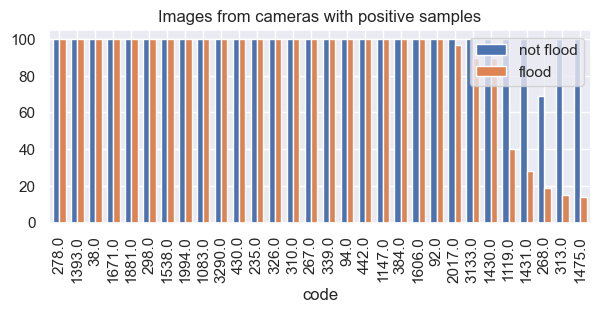

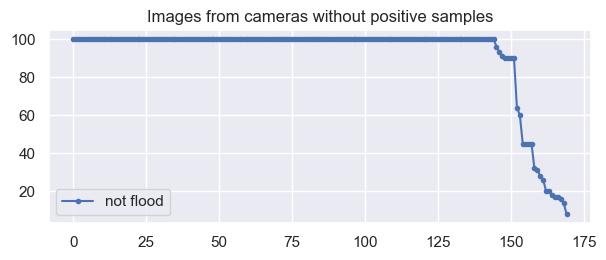

In [21]:
def separate_group_class_count_plot(y_even, groups_even, codes_1):
    
    groups_even_1 = groups_even[groups_even.isin(codes_1)]
    y_even_1 = y_even.loc[groups_even_1.index]
    
    cls_cnt = pd.concat([
        groups_even_1[y_even_1 == 0.0].value_counts().rename('not flood'),
        groups_even_1[y_even_1 == 1.0].value_counts().rename('flood')
    ], axis=1).sort_values('flood', ascending=False)
    
    fig = plt.figure(figsize=(7, 2.5))
    ax = fig.subplots(1, 1)
    
    cls_cnt.plot.bar(width=0.7, ax=ax)
    plt.title('Images from cameras with positive samples')
    plt.show()
    
    groups_even_0 = groups_even[groups_even.isin(codes_0)]
    y_even_0 = y_even.loc[groups_even_0.index]
    
    fig = plt.figure(figsize=(7, 2.5))
    ax = fig.subplots(1, 1)
    
    groups_even_0.value_counts().reset_index(drop=True).rename('not flood').plot(ax=ax, marker='o', ms=3)
    plt.title('Images from cameras without positive samples')
    plt.legend()
    plt.show()

separate_group_class_count_plot(y_even, groups_even, codes_1)

---
## 5. Train and Test Splits

### Imbalanced natural proportion per camera train, balanced test and validation

Groups intersecting train and test sets: 0
Groups intersecting train and val sets: 0
Groups intersecting test and val sets: 0



,groups,groups (%),total,total (%),0,1,0 (%),1 (%),class ratio (%)
train,119.0,59.5,13000.0,5.29,12526.0,474.0,5.57,2.27,96.35
test,6.0,3.0,1197.0,0.49,600.0,597.0,0.27,2.86,50.13
val,6.0,3.0,1042.0,0.42,600.0,442.0,0.27,2.12,57.58


codes,326.0,1393.0,1881.0,442.0,1147.0,267.0,384.0,92.0,3290.0,94.0,1994.0,339.0,1430.0,1083.0,3133.0,1119.0,313.0,268.0
Train,,,,,,,,,,,,,,,,,,
class 0,970,75,255,18,12,633,14,400,106,16,131,24,26,120,26,25,83,9
class 1,90,84,60,51,30,28,20,20,18,17,13,12,9,8,8,4,1,1


codes,278.0,1538.0,1671.0,38.0,310.0,2017.0
Test,,,,,,
class 0,100,100,100,100,100,100
class 1,100,100,100,100,100,97


codes,298.0,235.0,430.0,1606.0,1431.0,1475.0
Validation,,,,,,
class 0,100,100,100,100,100,100
class 1,100,100,100,100,28,14


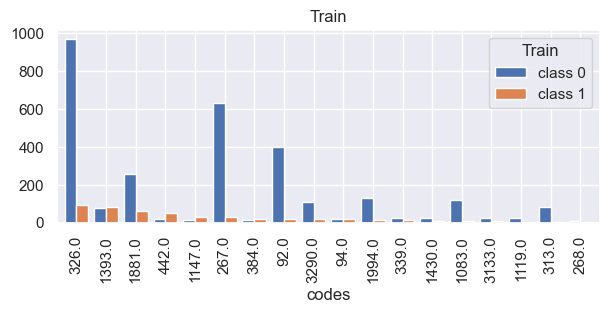

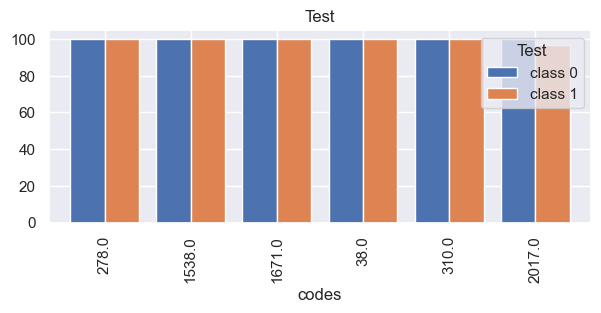

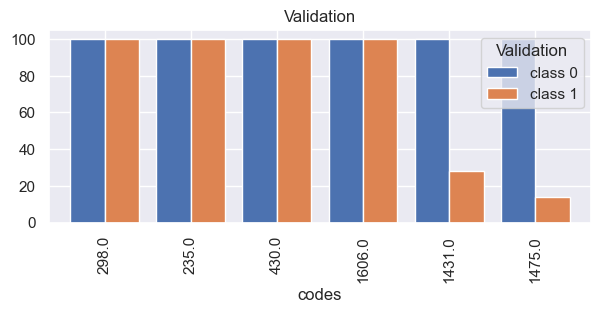

In [46]:
train_size = 13000

train_index = y[groups.isin(codes_train)].index
if train_size is not None:
    train_index = sample(list(train_index), size=train_size, seed=random_state)

test_index = y_even[groups_even.isin(codes_1_test)].index
val_index = y_even[groups_even.isin(codes_1_val)].index

display(group_split_report(y, groups, train_index, test_index, val_index))
group_class_count_plot(y, groups, train_index, test_index, val_index)

#### Copy images with `train_index`and `test_index` into structured 'train' and 'test' folders

In [47]:
from modules.octa_video_util import copy_images_to_folders

base_directory = 'data/images'
target_directory = 'data/splits/natural_imbalanced_train'
dataset = data.copy()
file_path_field = 'file_path'
label_field = 'flood'

copy_images_to_folders(
    base_directory, target_directory, dataset,
    train_index, test_index, val_index,
    file_path_field=file_path_field, tag_field=label_field
)

Copying images to train folders:
Processed 13000/13000 files (100.00%) - Found: 13000/13000
Copying images to test folders:
Processed 1197/1197 files (100.00%) - Found: 1197/1197
Copying images to val folders:


#### Save dataframe of sample images

In [176]:
import os

os.makedirs(target_directory, exist_ok=True)

data_train = data.loc[train_index].copy()
data_test = data.loc[test_index].copy()
data_val = data.loc[val_index].copy()

data_train['set'] = 'train'
data_test['set'] = 'test'
data_val['set'] = 'val'

data_split_df = pd.concat([data_train, data_test, data_val])

data_split_df.to_csv(f'{target_directory}/images.csv')
print(f'split dataframe saved with shape: {data_split_df.shape}')

split dataframe saved with shape: (1756, 13)


### Balanced train, test and validation

In [48]:
train_index = y_even[groups_even.isin(codes_1_train)].index
test_index = y_even[groups_even.isin(codes_1_test)].index
val_index = y_even[groups_even.isin(codes_1_val)].index

display(group_split_report(y_even, groups_even, train_index, test_index, val_index))
# group_class_count_plot(y, groups, train_index, test_index, val_index)

Groups intersecting train and test sets: 0
Groups intersecting train and val sets: 0
Groups intersecting test and val sets: 0



,groups,groups (%),total,total (%),0,1,0 (%),1 (%),class ratio (%)
train,18.0,9.0,3323.0,15.64,1769.0,1554.0,9.48,59.93,53.24
test,6.0,3.0,1197.0,5.63,600.0,597.0,3.22,23.02,50.13
val,6.0,3.0,1042.0,4.90,600.0,442.0,3.22,17.05,57.58


#### Copy images with `train_index`and `test_index` into structured 'train' and 'test' folders

In [49]:
from modules.octa_video_util import copy_images_to_folders

base_directory = 'data/images'
target_directory = 'data/splits/balanced_train'
dataset = data.copy()
file_path_field = 'file_path'
label_field = 'flood'

copy_images_to_folders(
    base_directory, target_directory, dataset,
    train_index, test_index, val_index,
    file_path_field=file_path_field, tag_field=label_field
)

Copying images to train folders:
Processed 3323/3323 files (100.00%) - Found: 3323/3323
Copying images to test folders:
Processed 1197/1197 files (100.00%) - Found: 1197/1197
Copying images to val folders:


#### Save dataframe of sample images

In [50]:
import os

os.makedirs(target_directory, exist_ok=True)

data_train = data.loc[train_index].copy()
data_test = data.loc[test_index].copy()
data_val = data.loc[val_index].copy()

data_train['set'] = 'train'
data_test['set'] = 'test'
data_val['set'] = 'val'

data_split_df = pd.concat([data_train, data_test, data_val])

data_split_df.to_csv(f'{target_directory}/images.csv')
print(f'split dataframe saved with shape: {data_split_df.shape}')

split dataframe saved with shape: (5562, 13)


### Imbalanced train,  balanced test and validation

In [51]:
train_index = y_even[groups_even.isin(codes_train)].index
test_index = y_even[groups_even.isin(codes_1_test)].index
val_index = y_even[groups_even.isin(codes_1_val)].index

display(group_split_report(y_even, groups_even, train_index, test_index, val_index))
# group_class_count_plot(y, groups, train_index, test_index, val_index)

Groups intersecting train and test sets: 0
Groups intersecting train and val sets: 0
Groups intersecting test and val sets: 0



,groups,groups (%),total,total (%),0,1,0 (%),1 (%),class ratio (%)
train,120.0,60.0,12918.0,60.78,11364.0,1554.0,60.90,59.93,87.97
test,6.0,3.0,1197.0,5.63,600.0,597.0,3.22,23.02,50.13
val,6.0,3.0,1042.0,4.90,600.0,442.0,3.22,17.05,57.58


#### Copy images with `train_index`and `test_index` into structured 'train' and 'test' folders

In [52]:
from modules.octa_video_util import copy_images_to_folders

base_directory = 'data/images'
target_directory = 'data/splits/imbalanced_train'

# dataset = data.copy()
dataset = data.copy()
file_path_field = 'file_path'
label_field = 'flood'

copy_images_to_folders(
    base_directory, target_directory, dataset,
    train_index, test_index, val_index,
    file_path_field=file_path_field, tag_field=label_field
)

Copying images to train folders:
Processed 12918/12918 files (100.00%) - Found: 12918/12918
Copying images to test folders:
Processed 1197/1197 files (100.00%) - Found: 1197/1197
Copying images to val folders:


#### Save dataframe of sample images

In [53]:
import os

os.makedirs(target_directory, exist_ok=True)

data_train = data.loc[train_index].copy()
data_test = data.loc[test_index].copy()
data_val = data.loc[val_index].copy()

data_train['set'] = 'train'
data_test['set'] = 'test'
data_val['set'] = 'val'

data_split_df = pd.concat([data_train, data_test, data_val])

data_split_df.to_csv(f'{target_directory}/images.csv')
print(f'split dataframe saved with shape: {data_split_df.shape}')

split dataframe saved with shape: (15157, 13)


#### Full imbalanced training set

In [43]:
test_size = 2000
val_size = 2000

train_index = y_even.index
test_index = list(set(y.index).difference(train_index))

if test_size is not None:
    test_index = sample(test_index, size=test_size, seed=random_state)

val_index = list(set(y.index).difference(train_index).difference(test_index))

if val_size is not None:
    val_index = sample(val_index, size=val_size, seed=random_state)

display(group_split_report(y, groups, train_index, test_index, val_index))
# group_class_count_plot(y, groups, train_index, test_index, val_index)

Groups intersecting train and test sets: 153
Groups intersecting train and val sets: 160
Groups intersecting test and val sets: 148



,groups,groups (%),total,total (%),0,1,0 (%),1 (%),class ratio (%)
train,200.0,100.0,21253.0,8.66,18660.0,2593.0,8.31,12.43,87.80
test,153.0,76.5,2000.0,0.81,1841.0,159.0,0.82,0.76,92.05
val,160.0,80.0,2000.0,0.81,1833.0,167.0,0.82,0.80,91.65


#### Copy images with `train_index`and `test_index` into structured 'train' and 'test' folders

In [44]:
from modules.octa_video_util import copy_images_to_folders

base_directory = 'data/images'
target_directory = 'data/splits/full_imbalanced_train'

# dataset = data.copy()
dataset = data.copy()
file_path_field = 'file_path'
label_field = 'flood'

copy_images_to_folders(
    base_directory, target_directory, dataset,
    train_index, test_index, val_index,
    file_path_field=file_path_field, tag_field=label_field
)


Copying images to test folders:
Processed 2000/2000 files (100.00%) - Found: 2000/2000
Copying images to val folders:


#### Save dataframe of sample images

In [45]:
import os

os.makedirs(target_directory, exist_ok=True)

data_train = data.loc[train_index].copy()
data_test = data.loc[test_index].copy()
data_val = data.loc[val_index].copy()

data_train['set'] = 'train'
data_test['set'] = 'test'
data_val['set'] = 'val'

data_split_df = pd.concat([data_train, data_test, data_val])

data_split_df.to_csv(f'{target_directory}/images.csv')
print(f'split dataframe saved with shape: {data_split_df.shape}')

split dataframe saved with shape: (25253, 13)
